In [2]:
!pip install d2l==0.17

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.7 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
from d2l import torch as d2l
%matplotlib inline

In [4]:
def get_data_transforms():
    """预处理"""
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomCrop(img_size, padding=16),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet均值
                             std=[0.229, 0.224, 0.225])
    ])
    test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    return train_transform, test_transform


In [15]:
def build_resnet50():
    # 加载ImageNet预训练的ResNet50
    model = models.resnet50(pretrained=True)
    # 分层训练
    for param in list(model.parameters())[:50]:
        param.requires_grad = False
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(in_features, 512),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(512),  # 稳定一下
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )
    for m in model.fc.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    model = model.to(device)
    return model
model = build_resnet50()

In [19]:
d2l.set_figsize()
device = d2l.try_gpu()
batch_size = 256
img_size = 224  # ResNet50适配输入尺寸（32×32→224×224）
num_classes = 10
epochs = 20
init_lr = 1e-3
weight_decay = 1e-4
save_path = "d2l_resnet50_cifar10_best.pth"
torch.save(model.state_dict(), "d2l_resnet50_cifar10_best.pth")

In [9]:
#加载数据集
train_transform, test_transform = get_data_transforms()


In [8]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_acc = 0.0
        self.counter = 0
        self.early_stop = False

    def __call__(self, current_acc):
        if current_acc > self.best_acc + self.min_delta:
            self.best_acc = current_acc
            self.counter = 0
            return True  #保存
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            return False

early_stopping = EarlyStopping(patience=10)

In [11]:
train_iter = load_cifar10(True, train_transform, batch_size)
test_iter = load_cifar10(False, test_transform, batch_size)

100%|██████████| 170M/170M [00:04<00:00, 42.2MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [17]:
optimizer = optim.AdamW(
    model.parameters(),
    lr=0.001,
    weight_decay=1e-4
)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)  # 学习率随epoch余弦衰减
criterion = nn.CrossEntropyLoss()

loss 0.002, train acc 0.974, test acc 0.942
138.9 examples/sec on [device(type='cuda', index=0)]


AttributeError: module 'd2l.torch' has no attribute 'evaluate_ch13'

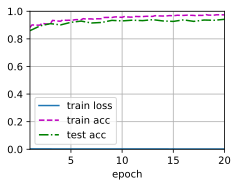

In [22]:
train_losses, train_accs = [], []
test_losses, test_accs = [], []


for epoch in range(epochs):

    train_metrics = d2l.train_ch13(
        model, train_iter, test_iter, criterion, optimizer, num_epochs=epochs, devices=[device]
    )
    test_metrics = d2l.evaluate_ch13(
        model, test_iter, criterion, devices
    )

    train_loss, train_acc = train_metrics
    test_loss, test_acc = test_metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f"测试集：损失={test_loss:.4f} | 准确率={test_acc:.4f}")


    scheduler.step()

In [ ]:
model.load_state_dict(torch.load(save_path))
final_test_loss, final_test_acc = d2l.evaluate_ch13(model, test_iter, criterion, device)
print(f"\n🎯 最终测试准确率：{final_test_acc:.4f}")


d2l.plt.figure(figsize=(12, 4))
d2l.plt.subplot(1, 2, 1)
d2l.plt.plot(range(1, len(train_losses)+1), train_losses, label="训练损失")
d2l.plt.plot(range(1, len(test_losses)+1), test_losses, label="测试损失")
d2l.plt.xlabel("轮次（Epoch）")
d2l.plt.ylabel("损失（Loss）")
d2l.plt.legend()
d2l.plt.title("损失曲线")

# 准确率
d2l.plt.subplot(1, 2, 2)
d2l.plt.plot(range(1, len(train_accs)+1), train_accs, label="训练准确率")
d2l.plt.plot(range(1, len(test_accs)+1), test_accs, label="测试准确率")
d2l.plt.xlabel("轮次（Epoch）")
d2l.plt.ylabel("准确率（Accuracy）")
d2l.plt.legend()
d2l.plt.title("准确率曲线")

d2l.plt.tight_layout()
d2l.plt.savefig("d2l_resnet50_cifar10_train_curve.png")
d2l.plt.show()